[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Denis-R-V/TSR/blob/main/notebooks/4.3.classifier_train.ipynb)

# Система распознавания дорожных знаков на датасете RTSD
## Обучение классификатора
Клиссификатор классифицирует дорожные знаки, которые обнаружил детектор

In [1]:
# если работаем в колабе - монтируем диск, ставим kaggle
try:
    from google.colab import drive
    drive.mount('/content/drive')

    !pip install kaggle -q
    
    colab=True
except:
    colab=False

In [2]:
import json
import os
import random
import sys
import time

import albumentations as A
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from albumentations.pytorch.transforms import ToTensorV2
from IPython.display import clear_output
from PIL import Image
from sklearn import metrics
from torch.utils.data import DataLoader, Dataset
#from torchvision import models
#from torchvision.models import resnet50, resnet152

sys.path.append('../src')
from download_datasets import (download_BelgiumTS, download_ChineseTS,
                               download_GTSRB, download_RTSD)

%matplotlib inline 

### Пути к данным

In [3]:
datasets_path = 'data/raw' if colab else os.path.join('..', 'data', 'raw')
data_prepared_path = '../content/drive/MyDrive/TSR/data/prepared' if colab else os.path.join('..', 'data', 'prepared')
models_path = '../content/drive/MyDrive/TSR/models' if colab else os.path.join('..', 'models')
metrics_path = '../content/drive/MyDrive/TSR/data/metrics' if colab else os.path.join('..', 'data', 'metrics')

In [4]:
# если работаем в колабе - скачиваем и распаковываем датасеты
if colab==True:
    !mkdir ~/.kaggle
    !cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json
    
    !kaggle datasets download watchman/rtsd-dataset
    
    !mkdir -p data/raw/RTSD
    !unzip -q rtsd-dataset.zip -d ./data/raw/RTSD/
    !rm rtsd-dataset.zip
    !cp -r data/raw/RTSD/rtsd-frames/rtsd-frames/ data/raw/RTSD
    !rm -r data/raw/RTSD/rtsd-frames/rtsd-frames/

    !kaggle datasets download meowmeowmeowmeowmeow/gtsrb-german-traffic-sign
    !mkdir data/raw/GTSRB
    !unzip -q gtsrb-german-traffic-sign.zip -d ./data/raw/GTSRB/
    !rm gtsrb-german-traffic-sign.zip

    !kaggle datasets download mahadevkonar/belgiumts-dataset
    !mkdir data/raw/BelgiumTS
    !unzip -q belgiumts-dataset.zip -d ./data/raw/BelgiumTS/
    !rm belgiumts-dataset.zip

    !kaggle datasets download dmitryyemelyanov/chinese-traffic-signs
    !mkdir data/raw/ChineseTS
    !unzip -q chinese-traffic-signs.zip -d ./data/raw/ChineseTS/
    !rm chinese-traffic-signs.zip

# если работаем локально и датасеты не скачаны - скачиваем
else:
    if os.path.exists(os.path.join(datasets_path, 'RTSD')) == False:
        download_RTSD(os.path.join(datasets_path, 'RTSD'))
    if os.path.exists(os.path.join(datasets_path, 'GTSRB')) == False:
        download_GTSRB(os.path.join(datasets_path, 'GTSRB'))    
    if os.path.exists(os.path.join(datasets_path, 'BelgiumTS')) == False:
        download_BelgiumTS(os.path.join(datasets_path, 'BelgiumTS'))
    if os.path.exists(os.path.join(datasets_path, 'ChineseTS')) == False:
        download_ChineseTS(os.path.join(datasets_path, 'ChineseTS'))

### Гиперпараметры

In [5]:
bg_samples_valid = 100        # количество экземпляров класса background на валидации
batch_size = 32
num_classes = 156

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(torch.cuda.get_device_name(0) if device.type == 'cuda' else device.type)

NVIDIA GeForce RTX 3090


In [6]:
with open(os.path.join(metrics_path, 'classifier_resnet152_bg100_default_b32_adam_001_b32_metrics.json'), 'r') as read_file:
        metr_def0 = json.load(read_file)
len(metr_def0['y_true_train'][-1])

96394

In [7]:
with open(os.path.join(metrics_path, 'classifier_resnet152_bg100_wGTSRB_default_b32_adam_001_b32_metrics.json'), 'r') as read_file:
        metr_gtsrb = json.load(read_file)
len(metr_gtsrb['y_true_train'][-1])

143493

In [8]:
with open(os.path.join(metrics_path, 'classifier_resnet152_bg100_wBelgiumTS_default_b32_adam_001_b32_metrics.json'), 'r') as read_file:
        metr_belg = json.load(read_file)
len(metr_belg['y_true_train'][-1])

101975

In [9]:
with open(os.path.join(metrics_path, 'classifier_resnet152_bg100_wChineseTS_default_b32_adam_001_b32_metrics.json'), 'r') as read_file:
        metr_def = json.load(read_file)
len(metr_def['y_true_train'][-1])

100758

In [10]:
# Ограничим количество экземпляров класса background для валидационной выборки
if not os.path.exists(os.path.join(data_prepared_path, f'val_anno_background_{bg_samples_valid}.json')):
    with open(os.path.join(data_prepared_path, 'val_anno_background.json'), 'r') as read_file:
        RTSD_valid_anno_background_short = json.load(read_file)
    RTSD_valid_anno_background_short['annotations'] = random.choices(RTSD_valid_anno_background_short['annotations'], k=bg_samples_valid)
    with open(os.path.join(data_prepared_path, f'val_anno_background_{bg_samples_valid}.json'), 'w') as f:
        json.dump(RTSD_valid_anno_background_short, f)#, cls=NpEncoder)

### Загрузчик данных

In [11]:
'''# Удаление категорий с количеством знаков меньше порога
sign_threshold = 10
filt = lambda x: x.sign.count() > sign_threshold
RTSD_train_exp_lim = RTSD_train_exp.groupby('category_id').filter(filt)

print("Количество уникальных категорий: {}".format(len(RTSD_train_exp.category_id.unique())))
RTSD_train_exp_lim''';

In [12]:
class dataset_for_classifier(Dataset):
    '''
    Класс объединяет объекты датасетов с аннотацией в формате COCO в один датасет
    При обращении к объекту он кадрируется по ограничивающей рамке
   
    параметры:
    images_anno_paths - список кортежей или списков с путями к изображениям и путями к аннотациям
    transforms        - набор преобразований изображения (аугментации, преобразование в тензор)
    samples_in_class  - при задании значения берется заданное количество экземплров класса
    bbox_expand_perc  - процент, на который увеличивается ограничивающая рамка знака
    bbox_expand_pixel - минимальное количество пикселей, на которое увеличивается ограничивающая рамка знака
    '''
    def __init__(self, images_anno_paths, transforms, samples_in_class=None,
                 bbox_expand_perc=None, bbox_expand_pixel=None):
        super().__init__()
        
        self.anno = self.make_anno_list(images_anno_paths)
        #self.anno = self.make_anno_df(images_anno_paths)
        
        # балансировка классов равным количество сэмплов
        if samples_in_class is not None:
            self.data_sampling(samples_in_class)

        self.transforms = transforms
        self.bbox_expand_perc = bbox_expand_perc/100 if bbox_expand_perc is not None else 0
        self.bbox_expand_pixel = bbox_expand_pixel if bbox_expand_pixel is not None else 0

    def __len__(self):      
        return len(self.anno)

    def __getitem__(self, index):
        
        if type(self.anno).__name__ == 'list':
            img_name = self.anno[index]['file_name']
            bbox = self.anno[index]['bbox']
            if (self.bbox_expand_perc !=0) or (self.bbox_expand_pixel !=0):
                width = self.anno[index]['width']
                height = self.anno[index]['height']
                bbox = self.expand_bbox(bbox, width, height)
            label = torch.tensor(self.anno[index]['category_id'])
        else:
            img_name = self.anno.at[index,'file_name']
            bbox = self.anno.at[index,'bbox']
            if (self.bbox_expand_perc is not None) or (self.bbox_expand_pixel is not None):
                width = self.anno.at[index,'width']
                height = self.anno.at[index,'height']
                bbox = self.expand_bbox(bbox, width, height)
            label = torch.tensor(self.anno.at[index,'category_id'])

        # Загрузка изображения
        #img = cv2.imread(os.path.join(self.root, path))
        #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # загрузка с помощью PIL оказалась быстрее, чем с помощью OpenCV
        img = Image.open(img_name)
        img = img.crop(bbox)
        
        img = self.transform(img)

        return {'images':img, 'labels':label}
    
    def make_anno_list(self, images_anno_paths):

        new_anno = []
        id=0                            # новый ID аннотации (нумерация сквозная)
        
        # для каждого файла аннотации в списке аннотаций
        for images_path, anno_path in images_anno_paths:
            
            # загрузка аннотации
            with open(anno_path, 'r') as read_file:
                anno = json.load(read_file)

            # аннотации изображений для более быстрого поиска по ID
            images_anno = {item['id']:item for item in anno['images']}
            # аннотации категорий для более быстрого поиска по ID
            categories_anno = {item['id']:item for item in anno['categories']}
            
            for annotation in anno.get('annotations'):
                
                sample = {}
                sample['id'] = id
                
                image_id = annotation['image_id']
                anno_image = images_anno[image_id]
                sample['file_name'] = os.path.join(images_path, anno_image['file_name'])
                sample['width'] = anno_image['width']
                sample['height'] = anno_image['height']

                x1, y1, w, h = annotation['bbox']
                sample['bbox'] = [round(x1), round(y1), round(x1+w), round(y1+h)]

                category_id = annotation['category_id']
                sample['category_id'] = category_id
                if category_id==0:
                    sample['category_name'] = 'background'
                else:
                    sample['category_name'] = categories_anno[category_id]['name']
                
                new_anno.append(sample)
                id+=1
        
        return new_anno
    
    def make_anno_df(self, images_anno_paths):

        # для каждого файла аннотации в списке аннотаций
        for images_path, anno_path in images_anno_paths:
            
            # загрузка аннотации
            with open(anno_path, 'r') as read_file:
                anno = json.load(read_file)

            # Загрузка аннотаций в датафрейм
            df_anno = pd.DataFrame(anno.get('annotations')) 
            
            # преобразование столбца bbox из формата COCO (x1, y1, w, h) в формат (x1, y1, x2, y2) и округление
            df_anno['bbox'] = df_anno['bbox'].apply(lambda x: [round(x[0]), round(x[1]), round(x[0] + x[2]), round(x[1] + x[3])])

            # Добавление путей к файлам
            
            df_images = pd.DataFrame(anno.get('images'))
            df_images['file_name'] = df_images['file_name'].apply(lambda x: os.path.join(images_path, x))
            df_anno = df_anno.merge(df_images, left_on='image_id', right_on='id')
            
            # Добавление имен категорий (кодов знаков)
            df_category = pd.DataFrame(anno.get('categories'))
            df_anno = df_anno.merge(df_category, left_on='category_id', right_on='id')[['file_name','width','height',
                                                                                          'bbox','category_id','name']]
            df_anno.rename(columns={'name':'category_name'}, inplace=True)
            
            # конкатенируем полученный датасет с общим датасетом
            try:
                new_anno = pd.concat((new_anno, df_anno), ignore_index=True)    
            except:      # если общего датасета еще нет - присваиваем ему полученный датасет
                new_anno = df_anno

        return new_anno
    
    def data_sampling(self, samples_in_class):
        if type(self.anno).__name__ == 'list':
            new_anno = []
            id=0
            categories = list(set([item['category_id'] for item in self.anno]))
            for category_id in categories:
                category_samples = [x for x in self.anno if x['category_id'] == category_id]
                for i in range(samples_in_class):
                    sample = random.choice(category_samples)
                    sample['id'] = id
                    new_anno.append(sample)
                    id+=1
                    
            self.anno = new_anno

        else:
            self.anno = self.anno.groupby('category_id', group_keys= False).apply(lambda x: x.sample(samples_in_class, replace=True))
            self.anno.reset_index(inplace=True)
            del self.anno['index']

    def expand_bbox(self, bbox, width, height):
        sign_w = bbox[2] - bbox[0]          # ширина знака
        sign_h = bbox[3] - bbox[1]          # высота знака
        
        # новые границы шире на bbox_expand_perc процентов, но не менее, чем на bbox_expand_pixel пикселей
        x1 = max(bbox[0] - round(max((sign_w*self.bbox_expand_perc), self.bbox_expand_pixel)), 0)
        y1 = max(bbox[1] - round(max((sign_h*self.bbox_expand_perc), self.bbox_expand_pixel)), 0)
        x2 = min(bbox[2] + round(max((sign_w*self.bbox_expand_perc), self.bbox_expand_pixel)), width)
        y2 = min(bbox[3] + round(max((sign_h*self.bbox_expand_perc), self.bbox_expand_pixel)), height)
        new_bbox = [x1, y1, x2, y2]

        return new_bbox
    
    def transform(self, img):
        if self.transforms.__module__ == 'torchvision.transforms.transforms':
            img = self.transforms(img)
        else:
            img = (self.transforms(image=np.array(img))['image'])/255
        return img

In [13]:
def get_transform(augmentation_lib = 'torchvision', train=False):
    if augmentation_lib =='torchvision':
        if train == True:
            return transforms.Compose([transforms.Resize((224,224)),
                                       transforms.RandomChoice([#transforms.Compose([transforms.RandomPerspective(distortion_scale=0.4,p=0.9),
                                                                #                    transforms.ToTensor()
                                                                #                    ]),
                                                                transforms.Compose([transforms.ColorJitter(brightness=(0.4), contrast=(0.3), saturation=(0.3)),
                                                                                    transforms.ToTensor()
                                                                                    ]),
                                                                transforms.Compose([transforms.RandomResizedCrop((224,224), scale=(0.85, 1)), # Случайная обрезка изображения в диапахоне 85 - 100% и resize в исходный размер
                                                                                    transforms.ToTensor()
                                                                                    ]),
                                                                transforms.Compose([transforms.ToTensor(),
                                                                                    transforms.RandomErasing(p = 0.4, scale = (0.003, 0.1)),
                                                                                    transforms.RandomErasing(p = 0.6, scale = (0.003, 0.05)),
                                                                                    transforms.RandomErasing(p = 0.6, scale = (0.003, 0.05)),
                                                                                    transforms.RandomErasing(p = 0.6, scale = (0.003, 0.02)),
                                                                                    transforms.RandomErasing(p = 0.6, scale = (0.003, 0.02)),
                                                                                    transforms.RandomErasing(p = 0.6, scale = (0.001, 0.01)),
                                                                                    transforms.RandomErasing(p = 0.6, scale = (0.001, 0.01)),
                                                                                    transforms.RandomErasing(p = 0.6, scale = (0.001, 0.01)),
                                                                                    transforms.RandomErasing(p = 0.6, scale = (0.001, 0.01)),
                                                                                    transforms.RandomErasing(p = 0.6, scale = (0.001, 0.01)),
                                                                                    ])        
                                                                ])
                                       ])
        else:
            return transforms.Compose([transforms.Resize((224,224)),
                                       transforms.ToTensor(),
                                       #transforms.Normalize([0.485, 0.456, 0.406],
                                       #                     [0.229, 0.224, 0.225])
                                       ])   
    
    elif augmentation_lib =='albumentations':
        if train==True:
            return A.Compose([A.augmentations.geometric.resize.Resize (224, 224, interpolation=1, always_apply=False, p=1),
                              A.augmentations.transforms.GaussNoise (var_limit=(0.01, 0.05), mean=0, per_channel=False, always_apply=False, p=0.2),
                              A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.8),
                              A.RandomFog(fog_coef_lower=0.2, fog_coef_upper=0.3, alpha_coef=0.1, p=0.05), #Туман
                              A.RandomRain(brightness_coefficient=0.9, drop_width=1, blur_value=5, p=0.05),
                              A.Rotate(limit=10, p=0.5),
                              ToTensorV2(p=1.0)
                              ])
            
        else:
            return A.Compose([A.augmentations.geometric.resize.Resize (224, 224, interpolation=1, always_apply=False, p=1),
                              ToTensorV2(p=1.0)
                              ])

In [14]:
def plot_sign(img, label=None):
    img = img.permute(1, 2, 0).detach().numpy()
    if label:
        print(f'Метка класса: {label}')
    fig, a = plt.subplots(1,1)
    fig.set_size_inches(2,2)
    a.imshow(img);

Визуализация примера аугментации с помощью библиотеки torchvision

Метка класса: 1


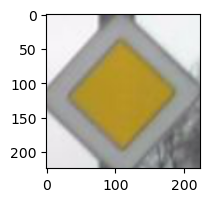

In [15]:
test = dataset_for_classifier([(os.path.join(datasets_path, 'RTSD'), os.path.join(datasets_path, 'RTSD', 'train_anno_reduced.json'))],
                                get_transform(augmentation_lib = 'torchvision', train=True))
sample = test.__getitem__(2)
plot_sign(sample['images'], sample['labels'])

Визуализация примера аугментации с помощью библиотеки Albumentations

Метка класса: 1


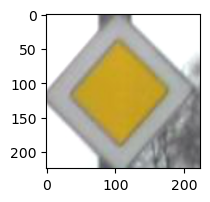

In [16]:
test = dataset_for_classifier([(os.path.join(datasets_path, 'RTSD'), os.path.join(datasets_path, 'RTSD', 'train_anno_reduced.json'))],
                                get_transform(augmentation_lib = 'albumentations', train=True))
sample = test.__getitem__(2)
plot_sign(sample['images'], sample['labels'])

In [17]:
train_dataset = dataset_for_classifier([(os.path.join(datasets_path, 'RTSD'), os.path.join(data_prepared_path, 'train_anno_reduced_background.json')),
                                        (os.path.join(datasets_path, 'RTSD'), os.path.join(datasets_path, 'RTSD', 'train_anno.json')),
                                        (os.path.join(datasets_path, 'GTSRB'), os.path.join(data_prepared_path, 'GTSRB_train_anno.json')),
                                        (os.path.join(datasets_path, 'GTSRB'), os.path.join(data_prepared_path, 'GTSRB_test_anno.json')),
                                        (os.path.join(datasets_path, 'BelgiumTS'), os.path.join(data_prepared_path, 'BelgiumTS_train_anno.json')),
                                        (os.path.join(datasets_path, 'BelgiumTS'), os.path.join(data_prepared_path, 'BelgiumTS_test_anno.json')),
                                        (os.path.join(datasets_path, 'ChineseTS'), os.path.join(data_prepared_path, 'ChineseTS_anno.json')),
                                        ],
                                        get_transform(augmentation_lib = 'torchvision', train=False))



valid_dataset = dataset_for_classifier([(os.path.join(datasets_path, 'RTSD'), os.path.join(data_prepared_path, f'val_anno_background_{bg_samples_valid}.json')),
                                      (os.path.join(datasets_path, 'RTSD'), os.path.join(datasets_path, 'RTSD', 'val_anno.json'))
                                      ],
                                      get_transform(augmentation_lib = 'torchvision', train=False))

In [18]:
'''# для эксперимента


train_dataset = dataset_for_classifier([(os.path.join(datasets_path, 'RTSD'), os.path.join(data_prepared_path, 'train_anno_reduced_background.json')),
                                        (os.path.join(datasets_path, 'RTSD'), os.path.join(datasets_path, 'RTSD', 'train_anno_reduced.json'))],
                                        get_transform(augmentation_lib = 'torchvision', train=False))

valid_dataset = dataset_for_classifier([(os.path.join(datasets_path, 'RTSD'), os.path.join(data_prepared_path, 'val_anno_background_100.json')),
                                      (os.path.join(datasets_path, 'RTSD'), os.path.join(datasets_path, 'RTSD', 'val_anno.json'))
                                      ],
                                      get_transform(augmentation_lib = 'torchvision', train=False));'''

"# для эксперимента\n\n\ntrain_dataset = dataset_for_classifier([(os.path.join(datasets_path, 'RTSD'), os.path.join(data_prepared_path, 'train_anno_reduced_background.json')),\n                                        (os.path.join(datasets_path, 'RTSD'), os.path.join(datasets_path, 'RTSD', 'train_anno_reduced.json'))],\n                                        get_transform(augmentation_lib = 'torchvision', train=False))\n\nvalid_dataset = dataset_for_classifier([(os.path.join(datasets_path, 'RTSD'), os.path.join(data_prepared_path, 'val_anno_background_100.json')),\n                                      (os.path.join(datasets_path, 'RTSD'), os.path.join(datasets_path, 'RTSD', 'val_anno.json'))\n                                      ],\n                                      get_transform(augmentation_lib = 'torchvision', train=False));"

### Формирование батча

In [19]:
train_data_loader = DataLoader(train_dataset,
                               #sampler=SubsetRandomSampler(),
                               batch_size=batch_size,
                               shuffle=True,
                               #collate_fn=collate_fn
                               )

valid_data_loader = DataLoader(valid_dataset,
                             #sampler=SubsetRandomSampler(),
                             batch_size=batch_size,
                             shuffle=False,
                             #collate_fn=collate_fn
                             )

### Параметры модели и обучения

In [20]:
#model_name = 'resnet152_bg100_tvs_full_colorjitter_04_03_03_resizedcrop_085_1_erasing_adam_001'
#model_name = 'resnet152_bg100_tvs_randomchoice_perspective_colorjitter_resizedcrop_erasing_adam_001'
#model_name = 'resnet152_bg100_alb_full_brightnesscontrast_03_03_p08_fog_p005_rain_p005_rotate_10_p05_adam_001'
#model_name = 'resnet152_sampled_full_tvs_adam_001'
#model_name = 'resnet152_add_signs_bg100_tvs_randomchoice_perspective_colorjitter_resizedcrop_erasing_adam_001_sh_10_06'
#model_name = 'resnet152_add_signs_sampled_bg100_alb_full_brightnesscontrast_03_03_p08_fog_p005_rain_p005_gaussnoise_001_02_p02_rotate_10_p05_adam_001'
#model_name = 'resnet152_bg100_alb_full_brightnesscontrast_03_03_p08_fog_p005_rain_p005_gaussnoise_001_02_p03_rotate_10_p05_adam_001'

model_name = 'resnet152_with_ChineseTS_bg100_tvs_randomchoice_colorjitter_resizedcrop_erasing_adam_001'

#model_name = 'resnet18_add_signs_bg300_tvs_randomchoice_perspective_colorjitter_resizedcrop_erasing_adam_001_amsgrad_sh_7_01'           # для эксперимента
model_name = 'classifier_resnet152_default_b32_adam_001'
model_name = 'resnet152_bg300_default_b32_adam_001'
model_name = 'resnet152_bg50_default_b32_adam_001'
model_name = 'resnet152_bg100_default_b64_adam_001'
model_name = 'resnet152_bg100_default_b128_adam_001'
model_name = 'resnet152_bg100_default_b256_adam_001'
model_name = 'resnet152_bg100_default_b512_adam_001'

model_name = 'resnet152_bg100_default_b32_adam_0001'
model_name = 'resnet152_bg100_default_b32_adam_0003'

model_name = 'resnet152_bg100_wGTSRB_default_b32_adam_001'
#model_name = 'resnet152_bg100_wBelgiumTS_default_b32_adam_001'
#model_name = 'resnet152_bg100_wChineseTS_default_b32_adam_001'
model_name = 'resnet152_bg100_wAll_default_b32_adam_001'

#optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
last_epoch = None
n_epochs = 10

### Инициализация модели, задание оптимизатора и функции потерь

In [21]:
def create_model(model_name, num_classes):
    
    if 'resnet152' in model_name.lower():
        model = torchvision.models.resnet152(weights='ResNet152_Weights.IMAGENET1K_V2')
        model.name = 'ResNet152'
    elif 'resnet50' in model_name.lower():
        model = torchvision.models.resnet50(weights='ResNet50_Weights.IMAGENET1K_V2')
    elif 'resnet18' in model_name.lower():
        model = torchvision.models.resnet18(weights='ResNet18_Weights.IMAGENET1K_V1')    
    else:
        model = None
    
    if model is None:
        print("Неверно указано название классификатора")
        return None   
    else:
        print(f'Создан классификатор {model_name}')
    
    for param in model.parameters():
        param.requires_grad = False
        
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    for param in model.fc.parameters():
        param.requires_grad = True

    return model.to(device)

In [22]:
model = create_model(model_name, num_classes)

loss_function = nn.CrossEntropyLoss()

# parameters
params = [p for p in model.parameters() if p.requires_grad]
# optimizer
#optimizer = torch.optim.SGD(params, lr=0.001, momentum=0.9, weight_decay=0.0005)
#optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.9, weight_decay=0.0005)
#optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
#optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)
#optimizer = torch.optim.Adam(model.parameters(), lr = 0.0003)

#optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=0.0005)
#optimizer = torch.optim.Adam(model.parameters(), amsgrad=True, lr=1.0e-3)#, weight_decay=1e-5)  # amsgrad=True

# a learning rate scheduler
#lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)
#lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.6)
#lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

# Decay LR by a factor of 0.1 every 7 epochs
#lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# Загрузка весов модели, состояния оптимизатора и шедулера, если продолжаем обучение с чекпойнта
if last_epoch is not None:
    checkpoint = torch.load(os.path.join(models_path, f'chkpt_classifier_{model_name}_{last_epoch}.pth'), map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    if 'lr_scheduler' in locals():
        lr_scheduler.load_state_dict(checkpoint['lr_scheduler_state_dict'])

Создан классификатор resnet152_bg100_wAll_default_b32_adam_001


### Трейн луп

In [23]:
def plot_training(current_train_loss=None, current_valid_loss=None, train_loss_history=None, valid_loss_history=None, train_accuracy_history=None, valid_accuracy_history=None,
                  train_f1_micro_history=None, valid_f1_micro_history=None, train_f1_macro_history=None, valid_f1_macro_history=None):

    fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(14, 8))
                
    clear_output(True)           
    if current_train_loss is not None:
        ax[0,0].plot(current_train_loss, label='train loss')
        ax[0,0].set_xlabel('Batch')
        ax[0,0].set_title(f'Train loss current epoch')
    elif current_valid_loss is not None:
        ax[0,0].plot(current_valid_loss, label='valid loss', color='orange')
        ax[0,0].set_xlabel('Batch')
        ax[0,0].set_title(f'valid loss current epoch')
                
    if train_loss_history is not None:
        ax[0,1].plot(train_loss_history, label='Train')
    if valid_loss_history is not None:
        ax[0,1].plot(valid_loss_history, label='valid')
    if (train_loss_history is not None) or (valid_loss_history is not None):
        ax[0,1].set_xlabel('Epoch')
        ax[0,1].set_title('General loss history')
        ax[0,1].legend()

    if train_accuracy_history is not None:
        ax[1,0].plot(train_accuracy_history, label='Train')
    if valid_accuracy_history is not None:
        ax[1,0].plot(valid_accuracy_history, label='valid')
    if (train_accuracy_history is not None) or (valid_accuracy_history is not None):
        ax[1,0].set_xlabel('Epoch')
        ax[1,0].set_title('General accuracy history')
        ax[1,0].legend()

    if train_f1_micro_history is not None:
        ax[1,1].plot(train_f1_micro_history, label='Train F1 micro')
    if valid_f1_micro_history is not None:
        ax[1,1].plot(valid_f1_micro_history, label='valid F1 micro')
    if train_f1_macro_history is not None:
        ax[1,1].plot(train_f1_macro_history, label='Train F1 macro')
    if valid_f1_macro_history is not None:
        ax[1,1].plot(valid_f1_macro_history, label='valid F1 macro')
    if (train_f1_micro_history is not None) or (valid_f1_micro_history is not None) or \
       (train_f1_macro_history is not None) or (valid_f1_macro_history is not None):
        ax[1,1].set_xlabel('Epoch')
        ax[1,1].set_title('General F1 history')
        ax[1,1].legend()
                
    plt.subplots_adjust(hspace=0.3)
    plt.show()
    
    return None

In [24]:
'''
# Отладка графика
def train(train_dataloader, epoch, plot=False, train_loss_history=None, valid_loss_history=None, 
          train_accuracy_history=None, valid_accuracy_history=None,
          train_f1_micro_history=None, valid_f1_micro_history=None,
          train_f1_macro_history=None, valid_f1_macro_history=None):

    running_loss = 0
    current_loss_history = []
    
    for i in range(len(train_dataloader)):

        loss = 1/((epoch+1)**1.3)*random.uniform(0.5,1.5)
        running_loss+=loss
        current_loss_history.append(loss)

        if i%5 == 0:

            time.sleep(0.1)
            plot_training(current_loss_history, None, train_loss_history, valid_loss_history, train_accuracy_history, valid_accuracy_history, train_f1_micro_history, valid_f1_micro_history, train_f1_macro_history, valid_f1_macro_history)
    
    train_loss = running_loss/len(train_dataloader)
    train_accuracy = (1/(1+np.exp(-epoch)))*random.uniform(0.9,1)
    train_f1_micro = (1/(1+np.exp(-epoch)))*random.uniform(0.85, 0.95)
    train_f1_macro = (1/(1+np.exp(-epoch)))*random.uniform(0.65, 0.80)
    train_f1_weighted=None

    return current_loss_history, train_loss, train_accuracy, train_f1_micro, train_f1_macro, train_f1_weighted
    

def eval(valid_dataloader, epoch, plot=False, train_loss_history=None, valid_loss_history=None,
         train_accuracy_history=None, valid_accuracy_history=None,
         train_f1_micro_history=None, valid_f1_micro_history=None,
         train_f1_macro_history=None, valid_f1_macro_history=None): 

    running_loss = 0
    current_loss_history = []
    
    for i in range(len(valid_dataloader)):

        loss = 1/((epoch+1)**1.3)*random.uniform(0.8,1.8)
        running_loss+=loss
        current_loss_history.append(loss)

        if i%5 == 0:

            time.sleep(0.05)
            
            plot_training(None, current_loss_history, train_loss_history, valid_loss_history, train_accuracy_history, valid_accuracy_history, train_f1_micro_history, valid_f1_micro_history, train_f1_macro_history, valid_f1_macro_history)
    
    valid_loss = running_loss/len(valid_dataloader)
    valid_accuracy = (1/(1+np.exp(-epoch)))*random.uniform(0.8, 0.9)
    valid_f1_micro = (1/(1+np.exp(-epoch)))*random.uniform(0.75, 0.85)
    valid_f1_macro = (1/(1+np.exp(-epoch)))*random.uniform(0.60, 0.75)
    valid_f1_weighted=None
    
    return current_loss_history, valid_loss, valid_accuracy, valid_f1_micro, valid_f1_macro, valid_f1_weighted 


def loop(n_epochs=10, plot=False):
    
    train_losses       = []
    valid_losses         = []
    train_accuracies   = []
    valid_accuracies     = []
    train_f1_micros    = []
    valid_f1_micros      = []
    train_f1_macros    = []
    valid_f1_macros      = []
    train_f1_weighteds = []
    valid_f1_weighteds   = []    
    
    try:
        for epoch in range(n_epochs):
        
            train_dataloader = [i for i in range(50)]
            last_epoch_train_loss, train_loss, train_accuracy, train_f1_micro, train_f1_macro, train_f1_weighted = train(train_dataloader, epoch, plot, train_losses, valid_losses,
                                                                                                                        train_accuracies, valid_accuracies, train_f1_micros, valid_f1_micros,
                                                                                                                        train_f1_macros, valid_f1_macros)

            valid_dataloader = [i for i in range(30)]
            
            last_epoch_valid_loss, valid_loss, valid_accuracy, valid_f1_micro, valid_f1_macro, valid_f1_weighted = eval(valid_dataloader, epoch, plot, train_losses, valid_losses,
                                                                                                            train_accuracies, valid_accuracies, train_f1_micros, valid_f1_micros,
                                                                                                            train_f1_macros, valid_f1_macros)

            train_losses.append(train_loss)
            valid_losses.append(valid_loss)
            train_accuracies.append(train_accuracy)
            valid_accuracies.append(valid_accuracy)
            train_f1_micros.append(train_f1_micro)
            valid_f1_micros.append(valid_f1_micro)
            train_f1_macros.append(train_f1_macro)
            valid_f1_macros.append(valid_f1_macro)
            train_f1_weighteds.append(train_f1_weighted)
            valid_f1_weighteds.append(valid_f1_weighted)
        
        if plot==True:
            plot_training(last_epoch_train_loss, None, train_losses, valid_losses, train_accuracies, valid_accuracies, train_f1_micros, valid_f1_micros, train_f1_macros, valid_f1_macros)

    except KeyboardInterrupt:
        if plot==True:
            plot_training(last_epoch_train_loss, None, train_losses, valid_losses, train_accuracies, valid_accuracies, train_f1_micros, valid_f1_micros, train_f1_macros, valid_f1_macros)
        print('Досрочно остановлено пользователем' + ' '*20)

    return None

loop(n_epochs=4, plot=True)''';

### TO DO
Добавить classification_report

In [25]:
def train(train_dataloader, epoch, plot=False, train_loss_history=None, valid_loss_history=None, 
          train_accuracy_history=None, valid_accuracy_history=None,
          train_f1_micro_history=None, valid_f1_micro_history=None,
          train_f1_macro_history=None, valid_f1_macro_history=None): 
    
    model.train()

    len_dataloader = len(train_dataloader)
    running_loss = 0
    current_loss_history = []

    # для текущего accuracy
    correct = 0.0
    total = 0.0
    
    # для вывода метрик
    y_true = []
    y_pred = []

    for batch_idx, batch in enumerate(train_dataloader):
        optimizer.zero_grad()
        images = batch['images'].to(device)
        targets = batch['labels'].to(device)

        output = model(images)
        loss = loss_function(output, targets)
        running_loss+=loss.item()
        current_loss_history.append(loss.item())  
        
        loss.backward()
        optimizer.step()   
        
        # вариант со средним running loss
        '''running_loss = running_loss + ((1/(batch_idx+1))*(loss.data-running_loss))                   более правильное        дополнить усреднением
        if batch_idx%5 == 0:
            print(f"Batch Id {batch_idx}/{len_dataloader} is having training loss of {running_loss}")
            print(f"Epoch #{epoch}. Accuracy on batch {batch_idx}/{len_dataloader}  on Training is {(100*correct/total)}")'''

        pred = output.data.max(1,keepdim=True)[1]

        # для текущего accuracy
        correct += np.sum(np.squeeze(pred.eq(targets.data.view_as(pred))).cpu().numpy())
        total += images.size(0)
        
        # для вывода метрик
        y_true.extend([int(item) for item in targets])
        y_pred.extend([int(item) for item in pred])

        train_loss = running_loss/len(train_dataloader.dataset)
        train_accuracy = metrics.accuracy_score(y_true, y_pred)
        train_f1_micro = metrics.f1_score(y_true, y_pred, average="micro")
        train_f1_macro =  metrics.f1_score(y_true, y_pred, average="macro")
        train_f1_weighted = metrics.f1_score(y_true, y_pred, average="weighted")

        if plot == True:
            # Рисуем график
            if batch_idx%10==0:
                plot_training(current_loss_history, None, train_loss_history, valid_loss_history, train_accuracy_history, valid_accuracy_history, train_f1_micro_history, valid_f1_micro_history, train_f1_macro_history, valid_f1_macro_history)

        else:
            if batch_idx%5 == 0:       #50
                print(f"\tEpoch: {epoch:02}. Iteration: {batch_idx}/{len_dataloader}. Train loss: {loss:.3f}. Train accuracy: {(100*correct/total):.2f}", end='\r')
    
    train_loss = running_loss/len(train_dataloader.dataset)
    
    return current_loss_history, train_loss, y_true, y_pred, train_accuracy, train_f1_micro, train_f1_macro, train_f1_weighted

#train(train_data_loader, 0)

In [26]:
def evaluate(valid_dataloader, epoch, plot=False, train_loss_history=None, valid_loss_history=None,
             train_accuracy_history=None, valid_accuracy_history=None,
             train_f1_micro_history=None, valid_f1_micro_history=None,
             train_f1_macro_history=None, valid_f1_macro_history=None): 

    model.eval()

    len_dataloader = len(valid_dataloader)
    running_loss = 0
    current_loss_history = []

    # для текущего accuracy
    correct = 0.0
    total = 0.0
    
    # для вывода метрик
    y_true = []
    y_pred = []
    
    for batch_idx, data in enumerate(valid_dataloader):
        optimizer.zero_grad()

        images = data['images'].to(device)
        targets = data['labels'].to(device)

        with torch.no_grad():
            output = model(images)
            loss = loss_function(output, targets)
        running_loss+=loss.item()                       # подумать над усреднением
        current_loss_history.append(loss.item())                        # пойдет для построения графика

        # вариант со средним running loss
        '''running_loss = running_loss + ((1/(batch_idx+1))*(loss.data-running_loss))
        if batch_idx%5 == 0:
            print(f"Batch Id {batch_idx}/{len_dataloader} is having training loss of {running_loss}")
            print(f"Epoch #{epoch}. Accuracy on batch {batch_idx}/{len_dataloader}  on Training is {(100*correct/total)}")'''

        pred = output.data.max(1,keepdim=True)[1]

        # для текущего accuracy
        correct += np.sum(np.squeeze(pred.eq(targets.data.view_as(pred))).cpu().numpy())
        total += images.size(0)
        
        # для вывода метрик
        y_true.extend([int(item) for item in targets])
        y_pred.extend([int(item) for item in pred])

        valid_loss = running_loss/len(valid_dataloader.dataset)
        valid_accuracy = metrics.accuracy_score(y_true, y_pred)
        valid_f1_micro = metrics.f1_score(y_true, y_pred, average="micro")
        valid_f1_macro =  metrics.f1_score(y_true, y_pred, average="macro")
        valid_f1_weighted = metrics.f1_score(y_true, y_pred, average="weighted")

        if plot == True:
            # Рисуем график
            if batch_idx%10==0:
                plot_training(None, current_loss_history, train_loss_history, valid_loss_history, train_accuracy_history, valid_accuracy_history, train_f1_micro_history, valid_f1_micro_history, train_f1_macro_history, valid_f1_macro_history)

        else:
            if batch_idx % 5 == 0:         # 50
                print(f"\tEpoch: {epoch:02}. Iteration: {batch_idx}/{len_dataloader}. valid loss: {loss:.3f}. valid accuracy: {(100*correct/total):.2f}", end='\r')
    valid_loss = running_loss/len(valid_dataloader.dataset)
    
    return current_loss_history, valid_loss, y_true, y_pred, valid_accuracy, valid_f1_micro, valid_f1_macro, valid_f1_weighted 

#evaluate(valid_data_loader, 0, plot=False)

In [27]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

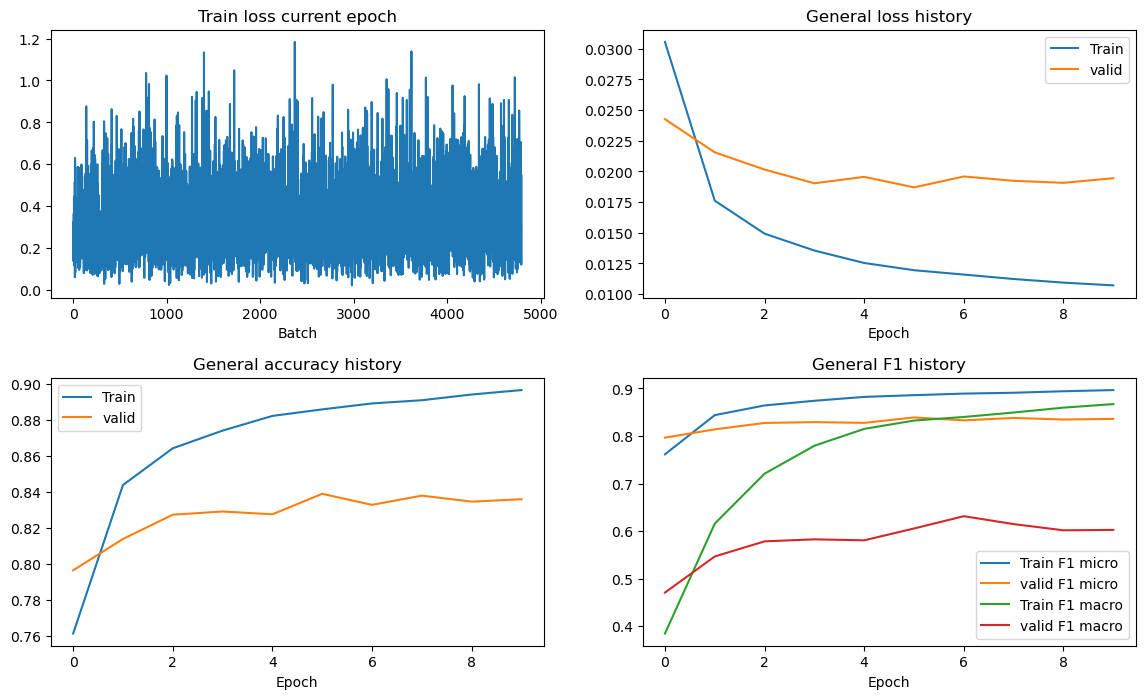

: 

In [28]:
def train_eval_loop(model, model_name, train_dataloader, valid_dataloader, last_epoch=None, n_epochs=10, plot=False, save_model_mode='all_best'):

    '''
    параметры:
    model_name        - имя модели для сохранения
    last_epoch        - последняя завершенная ранее эпоха обучения
    n_epochs          - количество эпох для обучения
    save_model_mode   - all - сохранение всех моделей
                      - all_best - сохранение всех моделей, у которых лосс на валидации меньше чем у предыдущей лучшей
                      - one_best - сохранение модели с наилучшим лоссом на валидации
                      - чекпойнт сохраняется каждую эпоху
    '''
    
    # эпоха, с которой начинается обучение
    start_epoch = last_epoch+1 if last_epoch is not None else 0
    
    # Загрузка словарей с лоссами и метриками
    train_losses       = checkpoint['losses_train']      if last_epoch is not None else []
    valid_losses       = checkpoint['losses_valid']      if last_epoch is not None else []
    y_true_train_all   = checkpoint['y_true_train_all']  if last_epoch is not None else []
    y_pred_train_all   = checkpoint['y_pred_train_all']  if last_epoch is not None else []
    y_true_valid_all   = checkpoint['y_true_valid_all']  if last_epoch is not None else []
    y_pred_valid_all   = checkpoint['y_pred_valid_all']  if last_epoch is not None else []
    train_accuracies   = checkpoint['accuracies_train']  if last_epoch is not None else []
    valid_accuracies   = checkpoint['accuracies_valid']  if last_epoch is not None else []
    train_f1_micros    = checkpoint['train_f1_micro']    if last_epoch is not None else []
    valid_f1_micros    = checkpoint['valid_f1_micro']    if last_epoch is not None else []
    train_f1_macros    = checkpoint['train_f1_macro']    if last_epoch is not None else []
    valid_f1_macros    = checkpoint['valid_f1_macro']    if last_epoch is not None else []
    train_f1_weighteds = checkpoint['train_f1_weighted'] if last_epoch is not None else []
    valid_f1_weighteds = checkpoint['valid_f1_weighted'] if last_epoch is not None else []    

    # наименьший лосс на валидации
    best_valid_loss    = min(valid_losses)               if last_epoch is not None else float('inf')
    
    try:    
        for epoch in range(start_epoch, n_epochs):
        
            start_time = time.time()

            train_dataloader = DataLoader(train_dataset,
                                          batch_size=batch_size,
                                          shuffle=True)

            last_epoch_train_losses, train_loss, y_true_train, y_pred_train, train_accuracy, train_f1_micro, train_f1_macro, train_f1_weighted = train(train_dataloader, epoch, plot, train_losses, valid_losses,
                                                                                                                           train_accuracies, valid_accuracies, train_f1_micros, valid_f1_micros,
                                                                                                                           train_f1_macros, valid_f1_macros)
            
            last_epoch_valid_losses, valid_loss, y_true_valid, y_pred_valid, valid_accuracy, valid_f1_micro, valid_f1_macro, valid_f1_weighted = evaluate(valid_dataloader, epoch, plot, train_losses, valid_losses,
                                                                                                                  train_accuracies, valid_accuracies, train_f1_micros, valid_f1_micros,
                                                                                                                  train_f1_macros, valid_f1_macros)
            if 'lr_scheduler' in locals():
                lr_scheduler.step()
            
            train_losses.append(train_loss)
            valid_losses.append(valid_loss)
            y_true_train_all.append(y_true_train),
            y_pred_train_all.append(y_pred_train),
            y_true_valid_all.append(y_true_valid),
            y_pred_valid_all.append(y_pred_valid),
            train_accuracies.append(train_accuracy)
            valid_accuracies.append(valid_accuracy)
            train_f1_micros.append(train_f1_micro)
            valid_f1_micros.append(valid_f1_micro)
            train_f1_macros.append(train_f1_macro)
            valid_f1_macros.append(valid_f1_macro)
            train_f1_weighteds.append(train_f1_weighted)
            valid_f1_weighteds.append(valid_f1_weighted)

            # сохранение чекпойнта
            torch.save({'epoch': epoch,
                        'model_state_dict': model.state_dict(),
                        'optimizer_state_dict': optimizer.state_dict(),
                        'lr_scheduler_state_dict': lr_scheduler.state_dict() if 'lr_scheduler' in locals() else None,
                        'transforms': str(train_dataset.transforms),
                        'losses_train': train_losses,
                        'losses_valid': valid_losses,
                        'y_true_train':y_true_train_all,
                        'y_pred_train':y_pred_train_all,
                        'y_true_valid':y_true_valid_all,
                        'y_pred_valid':y_pred_valid_all,
                        'accuracies_train': train_accuracies,
                        'accuracies_valid': valid_accuracies,
                        'f1_micros_train': train_f1_micros,
                        'f1_micros_valid': valid_f1_micros,
                        'f1_macros_train': train_f1_macros,
                        'f1_macros_valid': valid_f1_macros,
                        'f1_weighteds_train': train_f1_weighteds,
                        'f1_weighteds_valid': valid_f1_weighteds,
                        }, os.path.join(models_path, f'classifier_{model_name}_b{batch_size}_chkpt_{epoch}.pth'))
        
            # сохранение модели
            if save_model_mode == 'all':
                torch.save(model, os.path.join(models_path, f'classifier_{model_name}_b{batch_size}_model_{epoch}.pth'))
            elif valid_loss < best_valid_loss:
                best_valid_loss = valid_loss
                if save_model_mode == 'all_best':
                    torch.save(model, os.path.join(models_path, f'classifier_{model_name}_b{batch_size}_model_{epoch}.pth'))
                elif save_model_mode == 'one_best':
                    torch.save(model, os.path.join(models_path, f'classifier_{model_name}_b{batch_size}_model.pth'))

            # дополнительное сохранение словарей лоссов в json
            with open(os.path.join(metrics_path, f'classifier_{model_name}_b{batch_size}_metrics.json'), 'w') as fp:
                json.dump({'model_name':model.name,
                           'transforms':str(train_dataset.transforms),
                           'batch_size':batch_size,
                           'optimizer':str(optimizer),
                           'lr_scheduler': lr_scheduler.state_dict() if 'lr_scheduler' in locals() else None,
                           'losses_train':train_losses,
                           'losses_valid':valid_losses,
                           'y_true_train':y_true_train_all,
                           'y_pred_train':y_pred_train_all,
                           'y_true_valid':y_true_valid_all,
                           'y_pred_valid':y_pred_valid_all,
                           'accuracies_train': train_accuracies,
                           'accuracies_valid': valid_accuracies,
                           'f1_micros_train': train_f1_micros,
                           'f1_micros_valid': valid_f1_micros,
                           'f1_macros_train': train_f1_macros,
                           'f1_macros_valid': valid_f1_macros,
                           'f1_weighteds_train': train_f1_weighteds,
                           'f1_weighteds_valid': valid_f1_weighteds}, fp)

            end_time = time.time()
            epoch_mins, epoch_secs = epoch_time(start_time, end_time)
            
            if plot == False:
                print(f'Epoch: {epoch:02} | Time: {epoch_mins}m {epoch_secs}s | Train loss: {train_loss:.3f} | valid loss: {valid_loss:.3f}' + ' '*15)

        if plot==True:
            plot_training(last_epoch_train_losses, None, train_losses, valid_losses, train_accuracies, valid_accuracies, train_f1_micros, valid_f1_micros, train_f1_macros, valid_f1_macros)
    
    except KeyboardInterrupt:
        if plot==True:
            plot_training(last_epoch_train_losses, None, train_losses, valid_losses, train_accuracies, valid_accuracies, train_f1_micros, valid_f1_micros, train_f1_macros, valid_f1_macros)
        print('Досрочно остановлено пользователем' + ' '*40)

    return None

train_eval_loop(model, model_name, train_data_loader, valid_data_loader, last_epoch=None, n_epochs=n_epochs, plot=True, save_model_mode='one_best')